In [1]:
import pandas as pd
from nilearn import image, plotting, input_data, glm
#from nilearn.glm import threshold_stats_img
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
import matplotlib.pyplot as plt
import pdb

import warnings

warnings.filterwarnings('ignore')

In [2]:
#TS need to be standardized first 
subs = list(range(1001,1013))

#subs = list(range(1012,1005, -1))
#subs = list(range(1001,1006))
print(subs)
study ='spaceloc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
out_dir = f'{study_dir}/derivatives/fc'
results_dir = '/user_data/vayzenbe/GitHub_Repos/docnet/results'
exp = 'spaceloc'
rois = ['PPC_spaceloc', 'APC_spaceloc', 'PPC_depthloc', 'APC_depthloc', 'PPC_toolloc', 'APC_toolloc', 'PPC_distloc', 'APC_distloc']
control_tasks = ['distloc','toolloc','depthloc']

'''scan params'''
tr = 1
vols = 321

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = input_data.NiftiMasker(whole_brain_mask,
    smoothing_fwhm=0, standardize=True)

'''run info'''
run_num =6
runs = list(range(1,run_num+1))
run_combos = []
#determine the number of left out run combos
for rn1 in range(1,run_num+1):
    for rn2 in range(rn1+1,run_num+1):
        run_combos.append([rn1,rn2])


[1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012]


In [66]:
def make_psy_cov(runs,ss):
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
    cov_dir = f'{sub_dir}/covs'
    times = np.arange(0, vols*len(runs), tr)
    full_cov = pd.DataFrame(columns = ['onset','duration', 'value'])
    for rn, run in enumerate(runs):    
        
        curr_cov = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{run}_SA.txt', sep = '\t', header = None, names = ['onset','duration', 'value'])
        #contrasting (neg) cov

        curr_cont = pd.read_csv(f'{cov_dir}/SpaceLoc_{study}{ss}_Run{run}_FT.txt', sep = '\t', header =None, names =['onset','duration', 'value'])
        curr_cont.iloc[:,2] = curr_cont.iloc[:,2] *-1 #make contrasting cov neg
        
        curr_cov = curr_cov.append(curr_cont) #append to positive

        curr_cov['onset'] = curr_cov['onset'] + (vols*rn)
        full_cov = full_cov.append(curr_cov)
        #add number of vols to the timing cols based on what run you are on
        #e.g., for run 1, add 0, for run 2, add 321
        #curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) 
        #pdb.set_trace()
        
        #append to concatenated cov
    full_cov = full_cov.sort_values(by =['onset'])
    cov = full_cov.to_numpy()

    #convolve to hrf
    psy, name = glm.first_level.compute_regressor(cov.T, 'spm', times)
        

    return psy

,index,task,roi,x,y,z
0,0,spaceloc,lPPC,-27.577110,-60.926803,39.877867
1,0,distloc,lPPC,-20.057185,-76.111330,44.121811
2,0,toolloc,lPPC,-27.011573,-69.445802,50.593679
3,0,depthloc,lPPC,-25.909939,-75.853422,36.525090
4,0,spaceloc,lAPC,-28.103488,-56.093781,38.863286
...,...,...,...,...,...,...
265,10,toolloc,rLO,44.770055,-67.589841,-7.180723
266,11,toolloc,rLO,44.770055,-67.589841,-7.180723
267,12,toolloc,rLO,44.770055,-67.589841,-7.180723
268,13,toolloc,rLO,44.770055,-67.589841,-7.180723


In [2]:
def extract_roi_sphere(img, coords):
    roi_masker = input_data.NiftiSpheresMasker([tuple(coords)], radius = 6)
    seed_time_series = roi_masker.fit_transform(img)
    
    phys = np.mean(seed_time_series, axis= 1)
    #phys = (phys - np.mean(phys)) / np.std(phys) #TRY WITHOUT STANDARDIZING AT SOME POINT
    phys = phys.reshape((phys.shape[0],1))
    
    return phys

In [61]:
ss = 1001
tsk = 'spaceloc'
roi1 = 'rPPC'
roi2 = 'rLO'


In [84]:
sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
cov_dir = f'{sub_dir}/covs'
roi_dir = f'{sub_dir}/derivatives/rois'
exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')

curr_run = image.load_img(f'{exp_dir}/run-03/1stLevel.feat/filtered_func_data_reg.nii.gz')
curr_run = image.clean_img(curr_run,standardize=True)

img4d = curr_run

In [85]:
ppc_coord = roi_coords[(roi_coords['index'] == 0) & (roi_coords['task'] =='spaceloc') & (roi_coords['roi'] =='rPPC')]
lo_coord= roi_coords[(roi_coords['index'] == 0) & (roi_coords['task'] =='toolloc') & (roi_coords['roi'] =='rLO')]


In [86]:

ppc_ts = extract_roi_sphere(img4d,ppc_coord[['x','y','z']].values.tolist()[0])
lo_ts = extract_roi_sphere(img4d,lo_coord[['x','y','z']].values.tolist()[0])
data = pd.DataFrame(columns = ['ppc', 'lo'])
data['lo'] = np.squeeze(lo_ts)
data['ppc'] = np.squeeze(ppc_ts)


In [87]:
gc_res = grangercausalitytests(data[['lo','ppc']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5046  , p=0.0196  , df_denom=317, df_num=1
ssr based chi2 test:   chi2=5.5567  , p=0.0184  , df=1
likelihood ratio test: chi2=5.5090  , p=0.0189  , df=1
parameter F test:         F=5.5046  , p=0.0196  , df_denom=317, df_num=1


In [88]:
gc_res = grangercausalitytests(data[['ppc','lo']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0220  , p=0.0458  , df_denom=317, df_num=1
ssr based chi2 test:   chi2=4.0600  , p=0.0439  , df=1
likelihood ratio test: chi2=4.0345  , p=0.0446  , df=1
parameter F test:         F=4.0220  , p=0.0458  , df_denom=317, df_num=1


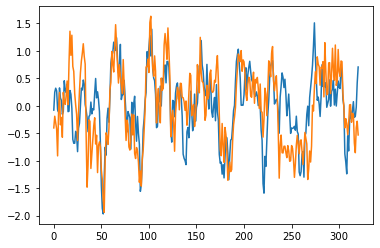

In [89]:
plt.plot(ppc_ts)
plt.plot(lo_ts)

In [ ]:
for ss in subs:
        print(ss)
        sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
        cov_dir = f'{sub_dir}/covs'
        roi_dir = f'{sub_dir}/derivatives/rois'
        exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

        roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')

        for tsk in ['spaceloc']:
            for rr in ['rPPC']:
                all_runs = [] #this will get filled with the data from each run
                for rcn, rc in enumerate(run_combos): #determine which runs to use for creating ROIs
                    curr_coords = roi_coords[(roi_coords['index'] == rcn) & (roi_coords['task'] ==tsk) & (roi_coords['roi'] ==rr)]

                    filtered_list = []
                    for rn in rc:
                        
                        curr_run = image.load_img(f'{exp_dir}/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz')
                        curr_run = image.clean_img(curr_run,standardize=True)
                        filtered_list.append(curr_run)

In [65]:

"""
Add LO to the ROI coords file
"""
parcels = ['LO']

for ss in subs:
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01'
    roi_dir = f'{sub_dir}/derivatives/rois'
    exp_dir = f'{sub_dir}/derivatives/fsl'
    parcel_dir = f'{roi_dir}/parcels'
    roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')
    roi_coords = roi_coords[roi_coords['roi'] != 'lLO']
    roi_coords = roi_coords[roi_coords['roi'] != 'rLO']
    
    
    
    for lr in ['l','r']:
        for pr in parcels:
            #load parcel
            roi = image.load_img(f'{parcel_dir}/{lr}{pr}.nii.gz')
            roi = image.math_img('img > 0', img=roi)

            control_zstat = image.load_img(f'{exp_dir}/toolloc/HighLevel_roi.gfeat/cope5.feat/stats/zstat1.nii.gz')
            coords = plotting.find_xyz_cut_coords(control_zstat,mask_img=roi, activation_threshold = .99)

            for rn in range(0,15):
                curr_coords = pd.Series([rn, 'toolloc', f'{lr}{pr}'] + coords, index=roi_coords.columns)
                roi_coords = roi_coords.append(curr_coords,ignore_index = True)

    roi_coords.to_csv(f'{roi_dir}/spheres/sphere_coords.csv', index=False)